In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile, io

## Straight loading dataset from UCI Repository website.

In [148]:
# Functions to load spam dataset
def load_spam_dataset():
    spam_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    _request_and_unzip(spam_url, "spam/")
    with open("datasets/spam/SMSSpamCollection", encoding="utf-8") as infile:
        d = infile.readlines()
    return d

def _request_and_unzip(url, folder):
    r = requests.get(url)
    if r.ok:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(f'datasets/{folder}')

data = load_spam_dataset()
len(data)

5574

## Converting to DataFrame

In [149]:
df = pd.DataFrame(data = data, columns = ["msg"])
df.head()

,msg
0,"ham\tGo until jurong point, crazy.. Available ..."
1,ham\tOk lar... Joking wif u oni...\n
2,spam\tFree entry in 2 a wkly comp to win FA Cu...
3,ham\tU dun say so early hor... U c already the...
4,"ham\tNah I don't think he goes to usf, he live..."


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   msg     5574 non-null   object
dtypes: object(1)
memory usage: 43.7+ KB


In [151]:
df.isna().sum()

msg    0
dtype: int64

## Data cleaning

In [152]:
df["label"] = df["msg"].str.split("\t").str[0]
df["msg"] = df["msg"].str.split("\t").str[1]
df.head()

,msg,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...\n,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [153]:
for message in enumerate(df["msg"][:5]):
    print(message)

(0, 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n')
(1, 'Ok lar... Joking wif u oni...\n')
(2, "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n")
(3, 'U dun say so early hor... U c already then say...\n')
(4, "Nah I don't think he goes to usf, he lives around here though\n")


In [154]:
df["msg"] = df["msg"].str.replace("\n", "", regex = True)
df.head()

,msg,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [155]:
for message in enumerate(df["msg"][:5]):
    print(message)

(0, 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')
(1, 'Ok lar... Joking wif u oni...')
(2, "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's")
(3, 'U dun say so early hor... U c already then say...')
(4, "Nah I don't think he goes to usf, he lives around here though")


## Re-order the columns

In [156]:
df = df.reindex(["label", "msg"], axis = 1)
df.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Plotting a histogram to see how many are ham and spam.

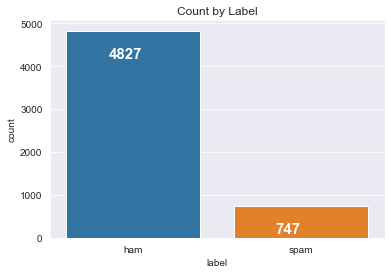

In [157]:
ax = sns.countplot(x = "label", data = df)
plt.title("Count by Label")
for v in ax.patches:
    ax.annotate(f"\n{v.get_height()}", (v.get_x()+0.25, v.get_height()), ha = "left", va = "top",
                color = "white", size = 15, weight = "bold")
plt.show()

## Use groupby also can have a glance of overview of the data.

In [158]:
df.groupby("label").describe()

msg                                                               
      count unique                                                top freq
label                                                                     
ham    4827   4518                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

## Feature Engineering
* We can add some new columns for this DataFrame because it's only has label and the contents of the text messages.
*  For instance the length of the each messages. Also can use sentiment analysis to find out the each messages belong to positive, negative or neutral, and sentiment scores as well. These also can be considered as the features for prediction in Machine Learning.



In [159]:
# df["full_length"] = df["msg"].str.len()  # Also can use df["msg"].map(len) or df["msg"].apply(len)
# df.head()

import string

def counter(txt):
    count = sum([1 for char in txt if char in string.punctuation])
    return round(count / (len(txt) - txt.count(" ")), 3) * 100


df["length"] = df["msg"].apply(lambda x: len(x) - x.count(" "))
df["punc_pct"] = df["msg"].apply(lambda x: counter(x))
df.head()

,label,msg,length,punc_pct
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8
1,ham,Ok lar... Joking wif u oni...,24,25.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7
3,ham,U dun say so early hor... U c already then say...,39,15.4
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1


In [160]:
print("Spam: Avg. Punctuation Percentage = {} and Avg. Length = {}".format(df[df['label'] == "spam"]['punc_pct'].mean(), 
                                                                                 df[df['label'] == "spam"]['length'].mean()))
print("Ham: Avg. Punctuation Percentage = {} and Avg. Length = {}".format(df[df['label'] == "ham"]['punc_pct'].mean(), 
                                                                                df[df['label'] == "ham"]['length'].mean()))


Spam: Avg. Punctuation Percentage = 4.891700133868805 and Avg. Length = 115.72289156626506
Ham: Avg. Punctuation Percentage = 7.474559767971791 and Avg. Length = 58.04433395483737


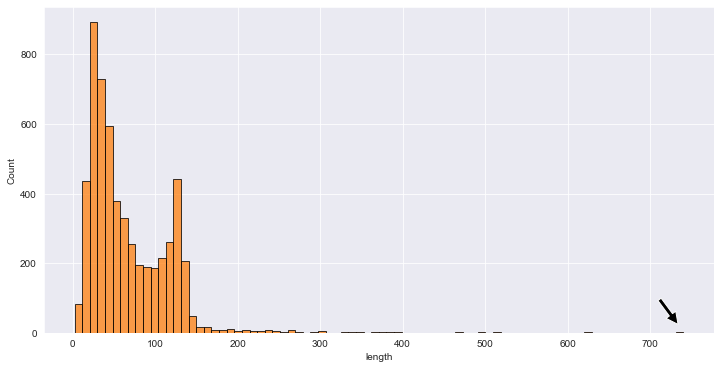

In [161]:
plt.figure(figsize = (12, 6))

ax = sns.histplot(x = "length", data = df, color = "tab:orange", bins = 80, ec = "k")

ax.annotate("", xy = (735, 20), xytext = (710, 100),
            arrowprops = dict(facecolor = "black", shrink = 0.05))
plt.show()

In [162]:
df["length"].nlargest() # <OR> df["body_length"].sort_values(ascending = False)

1085    740
1863    629
2434    511
1579    491
2158    464
Name: length, dtype: int64

In [163]:
df.iloc[1085]["msg"] # <OR> df[df["length"] == 740].iloc[0]["msg"]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

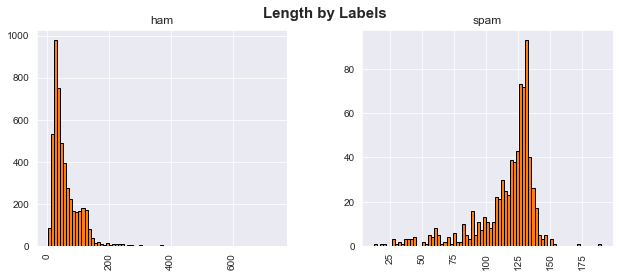

In [164]:
g = df.hist(column = "length", by = "label", figsize = (10, 4), bins = 75, color = "tab:orange", ec = "k")
plt.suptitle("Length by Labels", size = 15, weight = "bold")
plt.show()

## Sentiment Analysis
* Sentiment analysis usually uses on customer reviews, products rating, social media's comments etc
* But I will use Sentiment Analysis as part of the feature engineering for Machine Learning

In [165]:
# pip install nltk[all]

In [166]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Rating for the messages

In [167]:
def get_sentiment(row, **kwargs):
  sentiment_score = sid.polarity_scores(row)
  positive_meter = round((sentiment_score["pos"]), 3)
  negative_meter = round((sentiment_score["neg"]), 3)
  return positive_meter if kwargs["k"] == "positive" else negative_meter

In [168]:
df["positive"] = df["msg"].apply(get_sentiment, k = "positive")
df["negative"] = df["msg"].apply(get_sentiment, k = "negative")

df.head()

,label,msg,length,punc_pct,positive,negative
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,0.194,0.000
1,ham,Ok lar... Joking wif u oni...,24,25.0,0.577,0.000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,0.228,0.000
3,ham,U dun say so early hor... U c already then say...,39,15.4,0.000,0.000
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1,0.000,0.113


In [169]:
result = []

for index, row in df.iterrows():
  result.append("Positive: {}, Negative: {}".format(row["positive"], row["negative"]))

result[:10]

['Positive: 0.194, Negative: 0.0',
 'Positive: 0.577, Negative: 0.0',
 'Positive: 0.228, Negative: 0.0',
 'Positive: 0.0, Negative: 0.0',
 'Positive: 0.0, Negative: 0.113',
 'Positive: 0.305, Negative: 0.054',
 'Positive: 0.136, Negative: 0.212',
 'Positive: 0.11, Negative: 0.0',
 'Positive: 0.422, Negative: 0.0',
 'Positive: 0.294, Negative: 0.0']

In [170]:
df["scores"] = df["msg"].apply(lambda x: sid.polarity_scores(x))
df.head()

,label,msg,length,punc_pct,positive,negative,scores
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,0.194,0.000,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp..."
1,ham,Ok lar... Joking wif u oni...,24,25.0,0.577,0.000,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,0.228,0.000,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp..."
3,ham,U dun say so early hor... U c already then say...,39,15.4,0.000,0.000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1,0.000,0.113,"{'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'comp..."


In [171]:
df["compound"] = df["scores"].apply(lambda x: x["compound"])
df.head()

,label,msg,length,punc_pct,positive,negative,scores,compound
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,0.194,0.000,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.6249
1,ham,Ok lar... Joking wif u oni...,24,25.0,0.577,0.000,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...",0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,0.228,0.000,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.7964
3,ham,U dun say so early hor... U c already then say...,39,15.4,0.000,0.000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1,0.000,0.113,"{'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'comp...",-0.1027


In [172]:
df["comp_score"] = df["compound"].apply(lambda x: "pos" if x >= 0 else "neg")
df.head()

,label,msg,length,punc_pct,positive,negative,scores,compound,comp_score
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,0.194,0.000,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.6249,pos
1,ham,Ok lar... Joking wif u oni...,24,25.0,0.577,0.000,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...",0.4767,pos
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,0.228,0.000,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.7964,pos
3,ham,U dun say so early hor... U c already then say...,39,15.4,0.000,0.000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1,0.000,0.113,"{'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'comp...",-0.1027,neg


In [173]:
df["scores"].iloc[0]

{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6249}

## Count the frequency of positive and negative values

In [174]:
def rating(x):
  return "0% - 20%" if x <= 0.2 else "21% - 40%" if x <= 0.4 else "41% - 60%" if x <= 0.6 \
  else "61% - 80%" if x <= 0.8 else "81% - 100%"

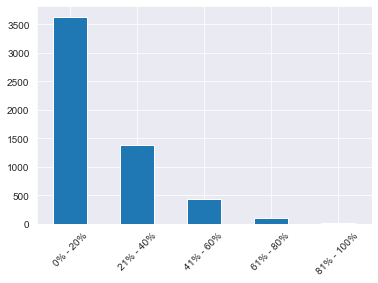

In [175]:
sns.set_style("darkgrid")
df["positive"].apply(rating).value_counts().plot(kind = "bar")
plt.xticks(rotation = 45)
plt.show()

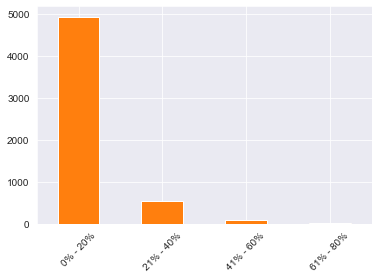

In [176]:
df["negative"].apply(rating).value_counts().plot(kind = "bar", color = "tab:orange")
plt.xticks(rotation = 45)
plt.show()

<AxesSubplot:>

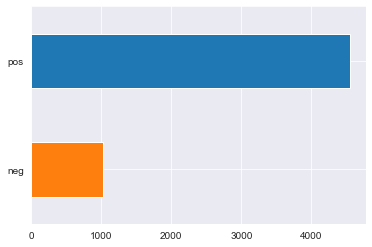

In [177]:
df["comp_score"].value_counts(ascending = True).plot(kind = "barh", color = ["tab:orange", "tab:blue"])

## Text Mining
* Tokenize > Stopwords > Lemmatize / Stemming

## Tokenization
* Removing Punctuations, lowering the letters, stripping whitespaces

In [178]:
nltk.download('punkt')
import string

def tokenizer(txt):
    txt = "".join([w.lower() for w in txt if w not in string.punctuation])
    txt = nltk.tokenize.word_tokenize(txt)  # United States >>> ["United", "States"]
    # txt = w.rstrip() for w in txt[-1] if w in [",", ".", "\n", ":", "!", "?", ";"]
    return txt
    # tokens = re.split("\W+", txt)
    # return tokens

df['msg_tokenized'] = df['msg'].apply(lambda x: tokenizer(x))  # I lower the letters here.
df.head(3)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,msg,length,punc_pct,positive,negative,scores,compound,comp_score,msg_tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,0.194,0.0,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.6249,pos,"[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,24,25.0,0.577,0.0,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...",0.4767,pos,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,0.228,0.0,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.7964,pos,"[free, entry, in, 2, a, wkly, comp, to, win, f..."


## Stopwords
* Removing the stopwords like printed on the next cell.


In [179]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [180]:
def stopwords_removal(txt):
  return [w for w in txt if w not in stopwords]


df["msg_sw_removed"] = df["msg_tokenized"].apply(stopwords_removal)
df.head(3)

,label,msg,length,punc_pct,positive,negative,scores,compound,comp_score,msg_tokenized,msg_sw_removed
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,0.194,0.0,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.6249,pos,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,24,25.0,0.577,0.0,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...",0.4767,pos,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,0.228,0.0,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.7964,pos,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."


## Categorizing the 'Ham' & 'Spam'
* Before going for the lemmatization and stemming, I would like to know what are the words have the most frequency in Ham and Spam.

In [181]:
spam_words = {}
ham_words = {}

for txt in df["msg_sw_removed"][df["label"] == "spam"]:

  for word in txt:
    if word not in spam_words:
      spam_words[word] = 1
    else:
      spam_words[word] += 1

for txt in df["msg_sw_removed"][df['label'] == "ham"]:

  for word in txt:
    if word in ham_words:
      ham_words[word] +=1
    else:
      ham_words[word] = 1


print("ham:", [v for v in ham_words.items()][:10], "\n")
print("spam:", [v for v in spam_words.items()][:10])

ham: [('go', 250), ('jurong', 1), ('point', 13), ('crazy', 10), ('available', 13), ('bugis', 7), ('n', 137), ('great', 100), ('world', 32), ('la', 7)] 

spam: [('free', 216), ('entry', 26), ('2', 173), ('wkly', 14), ('comp', 10), ('win', 60), ('fa', 4), ('cup', 5), ('final', 16), ('tkts', 4)]


## Optional - Sorting the highest occurences of the words in Dictionary

In [182]:
sorted_ham_words = dict(sorted(ham_words.items(), key = lambda kv: kv[1], reverse = True)) # 0 = k, 1 = v
sorted_spam_words = dict(sorted(spam_words.items(), key = lambda kv: kv[1], reverse = True))

print("Ham")
print(list(sorted_ham_words.items())[:5])   # Show first 5 items
# del sorted_ham_words[""]                    # Remove the '' which is an empty space
print(list(sorted_spam_words.items())[:5])  # Show first 5 items again

print("\nSpam")
print(list(sorted_spam_words.items())[:5])  # Show first 5 items
# del sorted_spam_words[""]                   # Remove the '' which is an empty space
print(list(sorted_ham_words.items())[:5])   # Show first 5 items again

Ham
[('u', 985), ('im', 451), ('2', 309), ('get', 303), ('ltgt', 276)]
[('call', 347), ('free', 216), ('2', 173), ('txt', 150), ('u', 148)]

Spam
[('call', 347), ('free', 216), ('2', 173), ('txt', 150), ('u', 148)]
[('u', 985), ('im', 451), ('2', 309), ('get', 303), ('ltgt', 276)]


## Visualizing the most occurences words
* Convert to a DataFrame easier for the plotting

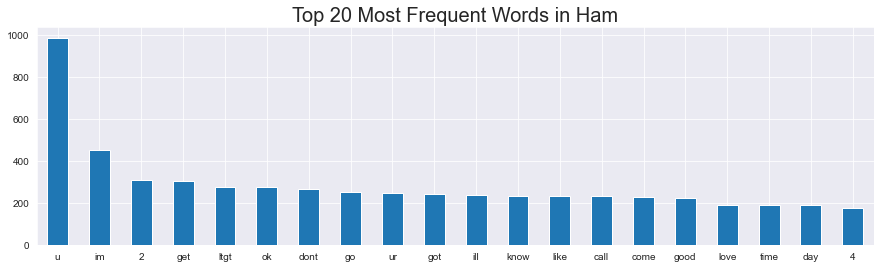

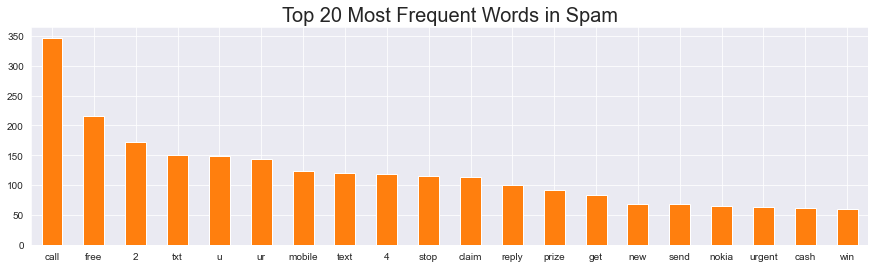

In [183]:
ham_df = pd.DataFrame.from_dict(ham_words, orient = "index", columns = ["freq"])
spam_df = pd.DataFrame.from_dict(spam_words, orient = "index", columns = ["freq"])


plt.figure(figsize = (15, 4))
ham_df["freq"].nlargest(20).plot(kind = "bar")
plt.xticks(rotation = 0)
plt.title("Top 20 Most Frequent Words in Ham", size = 20)

plt.figure(figsize = (15, 4))
spam_df["freq"].nlargest(20).plot(kind = "bar", color = "tab:orange")
plt.xticks(rotation = 0)
plt.title("Top 20 Most Frequent Words in Spam", size = 20)

plt.show()

## Lemmatization
* Refers to a vocaburaly and convert words to their base form.

In [184]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

print("mice    >", WordNetLemmatizer().lemmatize("mice"))
print("indices >", WordNetLemmatizer().lemmatize("indices"))
print("leaves  >", WordNetLemmatizer().lemmatize("leaves"))
print("cacti   >", WordNetLemmatizer().lemmatize("cacti"))

mice    > mouse
indices > index
leaves  > leaf
cacti   > cactus


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [185]:
lemma = WordNetLemmatizer()

def lemmatizer(txt):
  return " ".join([lemma.lemmatize(w) for w in txt])

df["msg_lemmatized"] = df["msg_sw_removed"].apply(lemmatizer)
df.head(3)

,label,msg,length,punc_pct,positive,negative,scores,compound,comp_score,msg_tokenized,msg_sw_removed,msg_lemmatized
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,0.194,0.0,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.6249,pos,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,24,25.0,0.577,0.0,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...",0.4767,pos,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,0.228,0.0,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.7964,pos,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...


## Stemming
* Works slightly different way compares to lemmatization. Stemming cutting out the end of words like the suffix in -ly, -ing, -ed, es, -ment etc.

In [186]:
from nltk.stem.porter import PorterStemmer

print("continuous  >", PorterStemmer().stem("continuous"))
print("purify      >", PorterStemmer().stem("purify"))
print("profile     >", PorterStemmer().stem("profile"))
print("people      >", PorterStemmer().stem("people"))
print("complicated >", PorterStemmer().stem("complicated"))

continuous  > continu
purify      > purifi
profile     > profil
people      > peopl
complicated > complic


In [187]:
from nltk.stem.porter import PorterStemmer

stem = PorterStemmer()

def stemmer(txt):
  return " ".join([stem.stem(w) for w in txt])


df["msg_stemmed"] = df["msg_sw_removed"].apply(stemmer)
df.head(3)

,label,msg,length,punc_pct,positive,negative,scores,compound,comp_score,msg_tokenized,msg_sw_removed,msg_lemmatized,msg_stemmed
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,0.194,0.0,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.6249,pos,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,24,25.0,0.577,0.0,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...",0.4767,pos,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,0.228,0.0,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.7964,pos,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...,free entri 2 wkli comp win fa cup final tkt 21...


## Bag of Words - CountVectorizer

In [188]:
from sklearn.feature_extraction.text import CountVectorizer

lemma_bow_transformer = CountVectorizer().fit(df["msg_lemmatized"])
stem_bow_transformer = CountVectorizer().fit(df["msg_stemmed"])

In [189]:
print(len(lemma_bow_transformer.vocabulary_))
print(len(stem_bow_transformer.vocabulary_))

8901
8092


In [190]:
############

In [191]:
lemma_bow_test = lemma_bow_transformer.transform([df["msg_lemmatized"][21]])  # must be in a list
print(lemma_bow_test, "\n")

stem_bow_test = stem_bow_transformer.transform([df["msg_stemmed"][21]])  # must be in a list
print(stem_bow_test)

  (0, 3632)	1
  (0, 3771)	2
  (0, 4436)	1
  (0, 5267)	1
  (0, 8053)	1 

  (0, 3314)	1
  (0, 3463)	2
  (0, 4060)	1
  (0, 4822)	1
  (0, 7286)	1


In [192]:
print(lemma_bow_transformer.get_feature_names()[3492])
print(stem_bow_transformer.get_feature_names()[3186])

funk
fujitsu


In [193]:
print(df["msg_lemmatized"][21])
print(df["msg_stemmed"][21])

‘ going try 2 month ha ha joking
‘ go tri 2 month ha ha joke


In [194]:
##################

In [195]:
lemma_bow = lemma_bow_transformer.transform(df["msg_lemmatized"])
stem_bow = stem_bow_transformer.transform(df["msg_stemmed"])

In [196]:
print("Shape of Sparse Matrix - Lemma:", lemma_bow.shape)
print("Shape of Sparse Matrix - Stem :", stem_bow.shape)

Shape of Sparse Matrix - Lemma: (5574, 8901)
Shape of Sparse Matrix - Stem : (5574, 8092)


In [197]:
print("Number of Non-Zero Occurences - Lemma:", lemma_bow.nnz)
print("Number of Non-Zero Occurences - Stem :", stem_bow.nnz)

Number of Non-Zero Occurences - Lemma: 47331
Number of Non-Zero Occurences - Stem : 47281


In [198]:
lemma_sparsity = (lemma_bow.nnz / (lemma_bow.shape[0] * lemma_bow.shape[1]) * 100)
stem_sparsity = (stem_bow.nnz / (stem_bow.shape[0] * stem_bow.shape[1]) * 100)

In [199]:
print("{:.4f}".format(lemma_sparsity))
print("{:.4f}".format(stem_sparsity))

0.0954
0.1048


## Normalizing

In [200]:
from sklearn.feature_extraction.text import TfidfTransformer

lemma_tfidf_fit = TfidfTransformer().fit(lemma_bow)
stem_tfidf_fit = TfidfTransformer().fit(stem_bow)

In [201]:
lemma_tfidf_transform = lemma_tfidf_fit.transform(lemma_bow)
stem_tfidf_transform = stem_tfidf_fit.transform(stem_bow)


print(lemma_tfidf_transform.shape)
print(stem_tfidf_transform.shape)

(5574, 8901)
(5574, 8092)


# Naïve Bayes Model

## Predicting without splitting into train set and test set

In [202]:
from sklearn.naive_bayes import MultinomialNB

lemma_nb = MultinomialNB().fit(lemma_tfidf_transform, df["label"])
stem_nb = MultinomialNB().fit(stem_tfidf_transform, df["label"])

In [203]:
lemma_pred = lemma_nb.predict(lemma_tfidf_transform)
stem_pred = stem_nb.predict(stem_tfidf_transform)

In [204]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(lemma_pred, df["label"]))
print(classification_report(lemma_pred, df["label"]))
print(confusion_matrix(stem_pred, df["label"]))
print(classification_report(stem_pred, df["label"]))

[[4827  116]
 [   0  631]]
              precision    recall  f1-score   support

         ham       1.00      0.98      0.99      4943
        spam       0.84      1.00      0.92       631

    accuracy                           0.98      5574
   macro avg       0.92      0.99      0.95      5574
weighted avg       0.98      0.98      0.98      5574

[[4827  115]
 [   0  632]]
              precision    recall  f1-score   support

         ham       1.00      0.98      0.99      4942
        spam       0.85      1.00      0.92       632

    accuracy                           0.98      5574
   macro avg       0.92      0.99      0.95      5574
weighted avg       0.98      0.98      0.98      5574



## Predicting with splitting into train set and test set as well as building a pipeline

In [205]:
from sklearn.model_selection import train_test_split

# Lemma
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(df["msg_lemmatized"], df["label"], test_size = 0.3,
                                                    random_state = 88)
# Stem
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df["msg_stemmed"], df["label"], test_size = 0.3,
                                                    random_state = 88)
# Original
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(df["msg"], df["label"], test_size = 0.3,
                                                    random_state = 88)

In [206]:
from sklearn.pipeline import Pipeline
# Creating Pipelines

# Lemma
pipe_nb_l = Pipeline([
                    ("bow", CountVectorizer()),
                    ("tfidf", TfidfTransformer()),
                    ("clf_nb", MultinomialNB())
                    ])
# Stem
pipe_nb_s = Pipeline([
                    ("bow", CountVectorizer()),
                    ("tfidf", TfidfTransformer()),
                    ("clf_nb", MultinomialNB())
                    ])
# Original
pipe_nb_o = Pipeline([
                    ("bow", CountVectorizer()),
                    ("tfidf", TfidfTransformer()),
                    ("clf_nb", MultinomialNB())
                    ])

In [207]:
from sklearn.metrics import accuracy_score

# Lemma
print("Results:", "\n" * 2, "*" * 14, "Lemma", "*" * 15)
pipe_nb_l.fit(X_train_l, y_train_l)
pred_nb_l = pipe_nb_l.predict(X_test_l)
acc_nb_l = accuracy_score(y_test_l, pred_nb_l)

print("Prediction Score :", acc_nb_l)
print("Accuracy Score   :", pipe_nb_l.score(X_test_l, y_test_l))


# Stem
print("\n", "*" * 15, "Stem", "*" * 15)
pipe_nb_s.fit(X_train_s, y_train_s)
pred_nb_s = pipe_nb_s.predict(X_test_s)
acc_nb_s = accuracy_score(y_test_s, pred_nb_s)

print("Prediction Score :", acc_nb_s)
print("Accuracy Score   :", pipe_nb_s.score(X_test_s, y_test_s))


# Original Message
print("\n", "*" * 12, "Original", "*" * 12)
pipe_nb_o.fit(X_train_o, y_train_o)
pred_nb_o = pipe_nb_o.predict(X_test_o)
acc_nb_o = accuracy_score(y_test_o, pred_nb_o)

print("Prediction Score :", acc_nb_o)
print("Accuracy Score   :", pipe_nb_o.score(X_test_o, y_test_o))

Results: 

 ************** Lemma ***************
Prediction Score : 0.958756724447101
Accuracy Score   : 0.958756724447101

 *************** Stem ***************
Prediction Score : 0.9563658099222953
Accuracy Score   : 0.9563658099222953

 ************ Original ************
Prediction Score : 0.9503885236102809
Accuracy Score   : 0.9503885236102809


# TensorFlow

In [208]:
# Map the labels as 0 and 1

df["label_encoded"] = df['label'].map({'ham': 0, 'spam': 1})

In [209]:
from sklearn.model_selection import train_test_split

# Lemma
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(df["msg_lemmatized"],
                                                            df["label_encoded"].values,
                                                            test_size = 0.2, random_state = 88)
# Stem
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df["msg_stemmed"],
                                                            df["label_encoded"].values,
                                                            test_size = 0.2, random_state = 88)
# Original
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(df["msg"], df["label_encoded"].values,
                                                            test_size = 0.2, random_state = 88)

## Defining the parameters
* This allows us to quickly adjust the parameters here without changing in cells by cells.

In [210]:
max_length = 50
trunc_type = "post"
pad_type = "post"
oov_token = "<OOV>"
vocab_size = 500

In [211]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_l = Tokenizer(num_words = vocab_size, char_level = False, oov_token = oov_token)
tokenizer_s = Tokenizer(num_words = vocab_size, char_level = False, oov_token = oov_token)
tokenizer_o = Tokenizer(num_words = vocab_size, char_level = False, oov_token = oov_token)

tokenizer_l.fit_on_texts(X_train_l)
tokenizer_s.fit_on_texts(X_train_s)
tokenizer_o.fit_on_texts(X_train_o)

In [212]:
##

In [213]:
word_index_l = tokenizer_l.word_index
word_index_s = tokenizer_s.word_index
word_index_o = tokenizer_o.word_index

# Lemma
print("[Lemma]", len(word_index_l), "unique tokens:-")
print({p: word_index_l[p] for p in list(word_index_l)[:10]}, "\n")

# Stem
print("[Stem]", len(word_index_s), "unique tokens:-")
print({p: word_index_s[p] for p in list(word_index_s)[:10]}, "\n")

# Original
print("[Original]", len(word_index_o), "unique tokens:-")
print({p: word_index_o[p] for p in list(word_index_o)[:10]})

[Lemma] 7875 unique tokens:-
{'<OOV>': 1, 'u': 2, 'call': 3, '2': 4, 'im': 5, 'get': 6, 'ur': 7, 'go': 8, '4': 9, 'free': 10} 

[Stem] 7188 unique tokens:-
{'<OOV>': 1, 'u': 2, 'call': 3, '2': 4, 'go': 5, 'im': 6, 'get': 7, 'ur': 8, 'come': 9, '4': 10} 

[Original] 7952 unique tokens:-
{'<OOV>': 1, 'i': 2, 'to': 3, 'you': 4, 'a': 5, 'the': 6, 'u': 7, 'and': 8, 'in': 9, 'is': 10}


## Sequencing and Padding

In [214]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Lemma
training_sequences_l = tokenizer_l.texts_to_sequences(X_train_l)
training_padded_l = pad_sequences(training_sequences_l, maxlen = max_length, padding = pad_type, truncating = trunc_type)

testing_sequences_l = tokenizer_l.texts_to_sequences(X_test_l)
testing_padded_l = pad_sequences(testing_sequences_l, maxlen = max_length, padding = pad_type, truncating = trunc_type)


# Stem
training_sequences_s = tokenizer_s.texts_to_sequences(X_train_s)
training_padded_s = pad_sequences(training_sequences_s, maxlen = max_length, padding = pad_type, truncating = trunc_type)

testing_sequences_s = tokenizer_s.texts_to_sequences(X_test_s)
testing_padded_s = pad_sequences(testing_sequences_s, maxlen = max_length, padding = pad_type, truncating = trunc_type)


# Original
training_sequences_o = tokenizer_o.texts_to_sequences(X_train_o)
training_padded_o = pad_sequences(training_sequences_l, maxlen = max_length, padding = pad_type, truncating = trunc_type)

testing_sequences_o = tokenizer_o.texts_to_sequences(X_test_o)
testing_padded_o = pad_sequences(testing_sequences_o, maxlen = max_length, padding = pad_type, truncating = trunc_type)


In [215]:
# Lemma
print("Shape of training tensor:", training_padded_l.shape)
print("Shape of testing tensor:", testing_padded_l.shape, "\n")

# Stem
print("Shape of training tensor:", training_padded_s.shape)
print("Shape of testing tensor:", testing_padded_s.shape, "\n")

# Original
print("Shape of training tensor:", training_padded_o.shape)
print("Shape of testing tensor:", testing_padded_o.shape)

Shape of training tensor: (4459, 50)
Shape of testing tensor: (1115, 50) 

Shape of training tensor: (4459, 50)
Shape of testing tensor: (1115, 50) 

Shape of training tensor: (4459, 50)
Shape of testing tensor: (1115, 50)


In [216]:
# Lemma
# Before padding
print(len(training_sequences_l[0]), len(training_sequences_l[1]))

# After padding
print(len(training_padded_l[0]), len(training_padded_l[1]), "\n")

# Stem
# Before padding
print(len(training_sequences_s[0]), len(training_sequences_s[1]))

# After padding
print(len(training_padded_s[0]), len(training_padded_s[1]), "\n")

# Original
# Before padding
print(len(training_sequences_o[0]), len(training_sequences_o[1]))

# After padding
print(len(training_padded_o[0]), len(training_padded_o[1]))

17 20
50 50 

17 20
50 50 

28 24
50 50


In [217]:
# Lemma
print(training_padded_l[0], "\n")

# Stem
print(training_padded_o[0], "\n")

# Original
print(training_padded_s[0])

[  1   1  46   1 205   2   1  74  62   3   1   1   1 223   1 198 244   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0] 

[  1   1  46   1 205   2   1  74  62   3   1   1   1 223   1 198 244   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0] 

[  1   1  48   1 213   2   1  79  70   3   1   1   1 235   1 209 261   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Defining additional parameters

In [218]:
embeding_dim = 16
drop_val = 0.2
n_dense = 24

## Building dense model and adding dropout

In [219]:
# Dense model architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

# Lemma
model_l = Sequential()
model_l.add(Embedding(vocab_size, embeding_dim, input_length = max_length))
model_l.add(GlobalAveragePooling1D())
model_l.add(Dense(n_dense, activation = "relu"))
model_l.add(Dropout(drop_val))
model_l.add(Dense(1, activation = "sigmoid"))

print(model_l.summary())

# Stem
model_s = Sequential()
model_s.add(Embedding(vocab_size, embeding_dim, input_length = max_length))
model_s.add(GlobalAveragePooling1D())
model_s.add(Dense(n_dense, activation = "relu"))
model_s.add(Dropout(drop_val))
model_s.add(Dense(1, activation = "sigmoid"))

print(model_s.summary())

# Original
model_o = Sequential()
model_o.add(Embedding(vocab_size, embeding_dim, input_length = max_length))
model_o.add(GlobalAveragePooling1D())
model_o.add(Dense(n_dense, activation = "relu"))
model_o.add(Dropout(drop_val))
model_o.add(Dense(1, activation = "sigmoid"))

print(model_o.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
Layer (type)             

## Compiling the Model

In [220]:
model_l.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_s.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_o.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

## Fitting a dense spam detector model

In [221]:

from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 30
early_stop = EarlyStopping(monitor = "val_loss", patience = 3)

# Training the model - For "msg_lemmatized"

In [222]:
history_l = model_l.fit(training_padded_l, y_train_l, epochs = num_epochs,
            validation_data = (testing_padded_l, y_test_l), callbacks = [early_stop], verbose = 2)

Epoch 1/30
140/140 - 2s - loss: 0.5167 - accuracy: 0.8491 - val_loss: 0.3713 - val_accuracy: 0.8592
Epoch 2/30
140/140 - 0s - loss: 0.3304 - accuracy: 0.8677 - val_loss: 0.3163 - val_accuracy: 0.8592
Epoch 3/30
140/140 - 0s - loss: 0.2588 - accuracy: 0.8706 - val_loss: 0.2369 - val_accuracy: 0.8798
Epoch 4/30
140/140 - 0s - loss: 0.1952 - accuracy: 0.9123 - val_loss: 0.1938 - val_accuracy: 0.9300
Epoch 5/30
140/140 - 0s - loss: 0.1566 - accuracy: 0.9439 - val_loss: 0.1618 - val_accuracy: 0.9426
Epoch 6/30
140/140 - 0s - loss: 0.1320 - accuracy: 0.9558 - val_loss: 0.1340 - val_accuracy: 0.9561
Epoch 7/30
140/140 - 0s - loss: 0.1107 - accuracy: 0.9621 - val_loss: 0.1151 - val_accuracy: 0.9650
Epoch 8/30
140/140 - 0s - loss: 0.0929 - accuracy: 0.9697 - val_loss: 0.0986 - val_accuracy: 0.9713
Epoch 9/30
140/140 - 0s - loss: 0.0829 - accuracy: 0.9760 - val_loss: 0.0939 - val_accuracy: 0.9686
Epoch 10/30
140/140 - 0s - loss: 0.0716 - accuracy: 0.9778 - val_loss: 0.0839 - val_accuracy: 0.9722

## Creating a DataFrame for the losses and accuracies

In [223]:
loss_df_l = pd.DataFrame(model_l.history.history)
loss_df_l.head()

,loss,accuracy,val_loss,val_accuracy
0,0.516689,0.849069,0.371331,0.859193
1,0.330430,0.867683,0.316285,0.859193
2,0.258795,0.870599,0.236880,0.879821
3,0.195187,0.912312,0.193779,0.930045
4,0.156571,0.943934,0.161820,0.942601


## Visualizing between two Losses

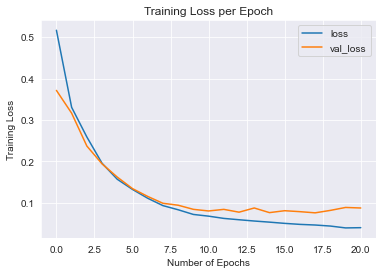

In [224]:
loss_df_l[["loss", "val_loss"]].plot()
plt.title("Training Loss per Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel ("Training Loss")
plt.show()

## Visualizing the accuracy

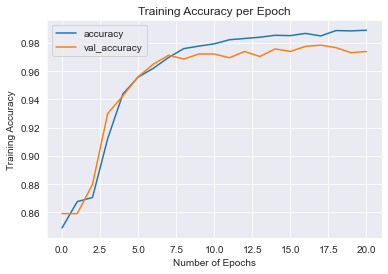

In [225]:
loss_df_l[["accuracy", "val_accuracy"]].plot()
plt.title("Training Accuracy per Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel ("Training Accuracy")
plt.show()

## Training the model - For "msg_stemmed"

In [226]:
history_s = model_s.fit(training_padded_s, y_train_s, epochs = num_epochs,
            validation_data = (testing_padded_s, y_test_s), callbacks = [early_stop], verbose = 2)

Epoch 1/30
140/140 - 1s - loss: 0.5304 - accuracy: 0.8625 - val_loss: 0.3787 - val_accuracy: 0.8592
Epoch 2/30
140/140 - 0s - loss: 0.3414 - accuracy: 0.8677 - val_loss: 0.3260 - val_accuracy: 0.8592
Epoch 3/30
140/140 - 0s - loss: 0.2859 - accuracy: 0.8681 - val_loss: 0.2586 - val_accuracy: 0.8592
Epoch 4/30
140/140 - 0s - loss: 0.2150 - accuracy: 0.9029 - val_loss: 0.1995 - val_accuracy: 0.9274
Epoch 5/30
140/140 - 0s - loss: 0.1677 - accuracy: 0.9412 - val_loss: 0.1620 - val_accuracy: 0.9471
Epoch 6/30
140/140 - 0s - loss: 0.1379 - accuracy: 0.9529 - val_loss: 0.1358 - val_accuracy: 0.9578
Epoch 7/30
140/140 - 0s - loss: 0.1171 - accuracy: 0.9581 - val_loss: 0.1176 - val_accuracy: 0.9605
Epoch 8/30
140/140 - 0s - loss: 0.0999 - accuracy: 0.9650 - val_loss: 0.1019 - val_accuracy: 0.9677
Epoch 9/30
140/140 - 0s - loss: 0.0870 - accuracy: 0.9693 - val_loss: 0.1032 - val_accuracy: 0.9623
Epoch 10/30
140/140 - 0s - loss: 0.0794 - accuracy: 0.9740 - val_loss: 0.0882 - val_accuracy: 0.9677

In [227]:
loss_df_s = pd.DataFrame(model_s.history.history)
loss_df_s.head()

,loss,accuracy,val_loss,val_accuracy
0,0.530399,0.862525,0.378727,0.859193
1,0.341429,0.867683,0.326024,0.859193
2,0.285941,0.868132,0.258574,0.859193
3,0.214994,0.902893,0.199498,0.927354
4,0.167718,0.941242,0.161985,0.947085


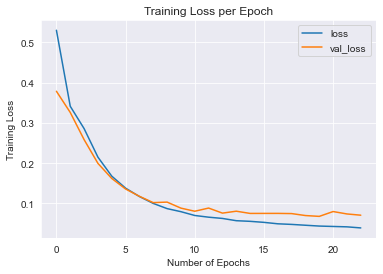

In [228]:
loss_df_s[["loss", "val_loss"]].plot()
plt.title("Training Loss per Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel ("Training Loss")
plt.show()

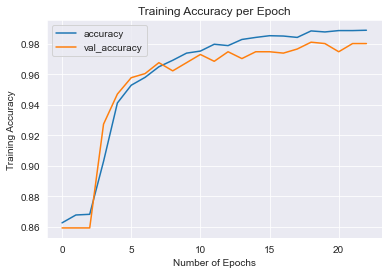

In [229]:
loss_df_s[["accuracy", "val_accuracy"]].plot()
plt.title("Training Accuracy per Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel ("Training Accuracy")
plt.show()

## Training the model - For "msg" (Original)
* Without punctuation removal, lemmatized, stemmed and vectorized.
* Although it has tokenized in sequencing and padding, but this Series had never done any modifications 'outside' of the TensorFlow.

In [230]:
history_o = model_o.fit(training_padded_o, y_train_o, epochs = num_epochs,
            validation_data = (testing_padded_o, y_test_o), callbacks = [early_stop], verbose = 2)

Epoch 1/30
140/140 - 2s - loss: 0.4837 - accuracy: 0.8666 - val_loss: 0.3793 - val_accuracy: 0.8592
Epoch 2/30
140/140 - 0s - loss: 0.3221 - accuracy: 0.8672 - val_loss: 0.3478 - val_accuracy: 0.8538
Epoch 3/30
140/140 - 0s - loss: 0.2435 - accuracy: 0.8820 - val_loss: 0.3284 - val_accuracy: 0.8341
Epoch 4/30
140/140 - 0s - loss: 0.1790 - accuracy: 0.9305 - val_loss: 0.3411 - val_accuracy: 0.8439
Epoch 5/30
140/140 - 0s - loss: 0.1454 - accuracy: 0.9534 - val_loss: 0.3800 - val_accuracy: 0.8377
Epoch 6/30
140/140 - 0s - loss: 0.1211 - accuracy: 0.9610 - val_loss: 0.4326 - val_accuracy: 0.8359


In [231]:
loss_df_o = pd.DataFrame(model_o.history.history)
loss_df_o.head()

,loss,accuracy,val_loss,val_accuracy
0,0.483664,0.866562,0.379303,0.859193
1,0.322077,0.867235,0.347846,0.853812
2,0.243518,0.882036,0.328420,0.834081
3,0.178962,0.930478,0.341088,0.843946
4,0.145425,0.953353,0.379997,0.837668


## Visualizing between two lossses

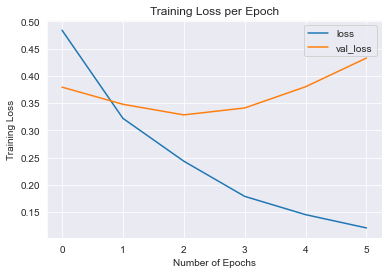

In [232]:
loss_df_o[["loss", "val_loss"]].plot()
plt.title("Training Loss per Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel ("Training Loss")
plt.show()

## Visualizing between two accuracy values

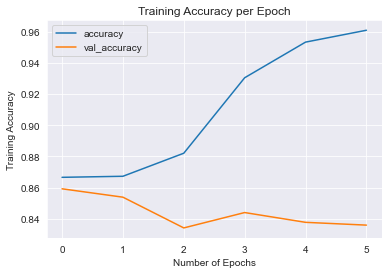

In [233]:
loss_df_o[["accuracy", "val_accuracy"]].plot()
plt.title("Training Accuracy per Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel ("Training Accuracy")
plt.show()

## Checking 3 of the evaluation results
* Model performance on test data - msg_lemmatized, msg_stemmed and msg.

In [234]:
# Lemma
print("Lemma:", model_l.evaluate(testing_padded_l, y_test_l), "\n")

# Stem
print("Stem:", model_s.evaluate(testing_padded_s, y_test_s), "\n")

# Original
print("Original:", model_o.evaluate(testing_padded_o, y_test_o))

35/35 [==============================] - 0s 1ms/step - loss: 0.0872 - accuracy: 0.9740
Lemma: [0.08718065172433853, 0.9739910364151001] 

35/35 [==============================] - 0s 1ms/step - loss: 0.0707 - accuracy: 0.9803
Stem: [0.07066758722066879, 0.9802690744400024] 

35/35 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.8359
Original: [0.4326479434967041, 0.8358744382858276]


Lemmatized msg has the highest accuracy, follow by stemmed_msg, and original msg.



---



# Additional - Spam Email Detector
* Creating a spam email detector based on a dataset
* Dataset can be downloaded [here](https://www.kaggle.com/balakishan77/spam-or-ham-email-classification?select=emails.csv)

In [235]:
email = pd.read_csv("D:/iCloud Drive/Colab_Data/emails.csv")
email.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [236]:
email["text"] = email["text"].str.replace("Subject: ", "")
email["text"] = email["text"].str.replace("re : ", "")

In [237]:
email.head()

,text,spam
0,naturally irresistible your corporate identity...,1
1,the stock trading gunslinger fanny is merrill...,1
2,unbelievable new homes made easy im wanting t...,1
3,4 color printing special request additional i...,1
4,"do not have money , get software cds from here...",1


In [238]:
email["spam"].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [239]:
def processor(txt):  # Rebuild a def func, copied the body from tokenizer, stopwords_removal above
   punc_removed = "".join([w.lower() for w in txt if w not in string.punctuation])
   tokenized = nltk.tokenize.word_tokenize(punc_removed)
   sw_removed = [w for w in tokenized if w not in stopwords]
   return sw_removed


email["processed"] = email["text"].apply(lambda x: processor(x))
print(email["processed"].head())

0    [naturally, irresistible, corporate, identity,...
1    [stock, trading, gunslinger, fanny, merrill, m...
2    [unbelievable, new, homes, made, easy, im, wan...
3    [4, color, printing, special, request, additio...
4    [money, get, software, cds, software, compatib...
Name: processed, dtype: object


In [240]:
def classify_words():
  spam_words = []
  n_spam_words = []

  for txt in email["processed"][email["spam"] == 1]:
    for word in txt:
      spam_words.append(word)

  for txt in email["processed"][email["spam"] == 0]:
    for word in txt:
      n_spam_words.append(word)

  return spam_words, n_spam_words

spam_words, n_spam_words = classify_words()


print(spam_words[:10])
print(n_spam_words[:10])

['naturally', 'irresistible', 'corporate', 'identity', 'lt', 'really', 'hard', 'recollect', 'company', 'market']
['hello', 'guys', 'bugging', 'completed', 'questionnaire', 'one', 'page', 'bio', 'statement', 'thoughts']


In [241]:
def predictor(sms):
  spam_counter = 0
  n_spam_counter = 0

  for word in sms:
    spam_counter += spam_words.count(word)
    n_spam_counter += n_spam_words.count(word)
    print("☆★☆ RESULTS ★☆★")

  if n_spam_counter > spam_counter:
    accuracy = round((n_spam_counter / (n_spam_counter + spam_counter) * 100))
    print("Email is not spam, with {}% certainty".format(accuracy))

  elif n_spam_counter == spam_counter:
    print('Email could be spam')

  else:
    accuracy = round((spam_counter / (n_spam_counter + spam_counter) * 100))
    print("Email is spam, with {}% certainty".format(accuracy))

In [242]:
input_msg = processor(input("Please copy and paste your email subject or its body message:\n\n"))
predictor(input_msg)

Please copy and paste your email subject or its body message:

Reply immediately! You have a parcel with DHL.
☆★☆ RESULTS ★☆★
☆★☆ RESULTS ★☆★
☆★☆ RESULTS ★☆★
☆★☆ RESULTS ★☆★
Email is not spam, with 65% certainty
